In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime
import seaborn as sns

In [9]:
import dwave
from dwave.cloud import Client
client = Client.from_config(config_file= '/home/rajarsi/.config/dwave/dwave.conf' )
dwave.cloud.config.load_config(['/home/rajarsi/.config/dwave/dwave.conf'])
import dimod
import neal
from dwave.system import LeapHybridCQMSampler, DWaveSampler , LeapHybridSampler
from dimod import BinaryQuadraticModel as BQM
from dimod import ConstrainedQuadraticModel as CQM


#### Scratch 

In [3]:
## define bqm ~
bqm = BQM({'x':2, 'y':-1,'z':1},{ ('x','y'):-1, ('x','z'): -2, ('y','z'): 1}, 0 , 'SPIN')
bqm


BinaryQuadraticModel({'x': 2.0, 'y': -1.0, 'z': 1.0}, {('y', 'x'): -1.0, ('z', 'x'): -2.0, ('z', 'y'): 1.0}, 0.0, 'SPIN')

In [5]:
## convert to CQM and add constraints ~
cqm = CQM.from_bqm(bqm)
cqm.add_constraint_from_iterable([('x','z',2), ('x',1), ('y', -1), ('y','z', 1) ], '<=', rhs= 3 , label= 'c1')
cqm.constraints['c1'].to_polystring()
# cqm.objective

'x - y + 2*x*z + z*y <= 3'

In [18]:
## setup sampler 
sampler = LeapHybridSampler()
smpl_set = sampler.sample(bqm)

In [20]:
print(smpl_set)

  AAPL AMZN FB GOOGL IBM JPC MSFT TSLA    energy num_oc.
0    1    0  0     1   0   0    1    1 -0.007342       1
['BINARY', 1 rows, 1 samples, 8 variables]


### Example: Portfolio Optmisation

##### Getting Stock Data

In [12]:
def get_stock_data(stocks, start= datetime.datetime(2000,1,1) , end= datetime.datetime(2022,1,1) ) :
    """ Return stock data and covariace matrix corresponding to it """
    data = pd.DataFrame()
    for stock in stocks:
         data[stock] = pdr.DataReader(stock,data_source='yahoo', start= start, end= end)['Adj Close']

    rtrn_data = data/data.shift(1)
    rtrn_data =  np.log(rtrn_data[1:])
    cov_matrix = rtrn_data.cov()
    return rtrn_data, cov_matrix

In [13]:
stocks= ['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']
data = get_stock_data(stocks)


In [14]:
cov_matrix = data[1]
mean_rtrn = data[0].mean()
for stock in stocks : cov_matrix[stock][stock] = 0

<AxesSubplot:>

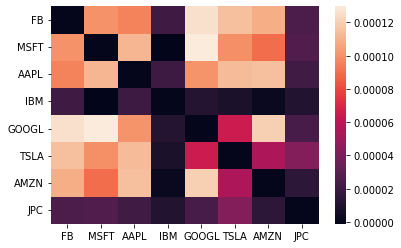

In [15]:
sns.heatmap(cov_matrix)

##### Setting up BQM

In [21]:
bqm = BQM('BINARY')
for stock in stocks : bqm.add_variable(stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: bqm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: bqm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        
# bqm

##### Simulated Annealing solver

In [22]:
sampler = neal.SimulatedAnnealingSampler()
sampler.properties, sampler.parameters

({'beta_schedule_options': ('linear', 'geometric')},
 {'beta_range': [],
  'num_reads': [],
  'num_sweeps': [],
  'beta_schedule_type': ['beta_schedule_options'],
  'seed': [],
  'interrupt_function': [],
  'initial_states': [],
  'initial_states_generator': []})

In [23]:
pf_op = sampler.sample(bqm, num_sweeps= 100, num_sweeps_per_beta= 50, num_reads= 10 ,beta_schedule= 'geometric' ,seed= 1234)

In [24]:
## most optimal solution 
pf_op.first


Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 0, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.007341724543759465, num_occurrences=1)

##### Setting up CQM

In [29]:
weights = [.9, .7, .2, .1]
y = [dimod.Binary(f'y_{j}') for j in range(len(weights))]
x = [[dimod.Binary(f'x_{i}_{j}') for j in range(len(weights))]
     for i in range(len(weights))]
cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(sum(y))

In [30]:
x

[[BinaryQuadraticModel({'x_0_0': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_0_1': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_0_2': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_0_3': 1.0}, {}, 0.0, 'BINARY')],
 [BinaryQuadraticModel({'x_1_0': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_1_1': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_1_2': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_1_3': 1.0}, {}, 0.0, 'BINARY')],
 [BinaryQuadraticModel({'x_2_0': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_2_1': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_2_2': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_2_3': 1.0}, {}, 0.0, 'BINARY')],
 [BinaryQuadraticModel({'x_3_0': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_3_1': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_3_2': 1.0}, {}, 0.0, 'BINARY'),
  BinaryQuadraticModel({'x_3_3': 1.0}, {}, 0.0, 'BINARY')]]

In [44]:
cqm = CQM.from_bqm(bqm)
# cqm.objective

In [45]:
vars = cqm.variables
vars =  [dimod.Binary(var) for var in vars ]
vars

[BinaryQuadraticModel({'FB': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'MSFT': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'AAPL': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'IBM': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'GOOGL': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'TSLA': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'AMZN': 1.0}, {}, 0.0, 'BINARY'),
 BinaryQuadraticModel({'JPC': 1.0}, {}, 0.0, 'BINARY')]

In [46]:
cqm.add_constraint(sum(vars) <= len(vars), label= 'stock constraint')

'stock constraint'

In [48]:
cqm.constraints

{'stock constraint': Le(BinaryQuadraticModel({'FB': 1.0, 'MSFT': 1.0, 'AAPL': 1.0, 'IBM': 1.0, 'GOOGL': 1.0, 'TSLA': 1.0, 'AMZN': 1.0, 'JPC': 1.0}, {}, 0.0, 'BINARY'), 8)}

In [50]:
from dimod import ExactCQMSolver
sample_set = ExactCQMSolver().sample_cqm(cqm)

In [55]:
sample_set.first

Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 0, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.007341724543759468, num_occurrences=1, is_satisfied=array([ True]), is_feasible=True)

In [49]:
sampler_cqm = LeapHybridCQMSampler()
sample_set = sampler_cqm.sample(cqm)

AttributeError: 'LeapHybridCQMSampler' object has no attribute 'sample'